In [12]:
# %pip install google-generativeai
# %pip install pydantic
# %pip install Pillow
# %pip install llama_index
# %pip install matplotlib

# %pip install llama-index-multi-modal-llms-gemini
# %pip install llama-index-vector-stores-qdrant
# %pip install llama-index-embeddings-gemini
# %pip install llama-index-llms-gemini

In [22]:
for model in genai.list_models():
    print(model.name)

models/chat-bison-001
models/text-bison-001
models/embedding-gecko-001
models/gemini-1.0-pro-latest
models/gemini-1.0-pro
models/gemini-pro
models/gemini-1.0-pro-001
models/gemini-1.0-pro-vision-latest
models/gemini-pro-vision
models/gemini-1.5-pro-latest
models/gemini-1.5-pro-001
models/gemini-1.5-pro
models/gemini-1.5-pro-exp-0801
models/gemini-1.5-flash-latest
models/gemini-1.5-flash-001
models/gemini-1.5-flash
models/embedding-001
models/text-embedding-004
models/aqa


In [23]:
import google.generativeai as genai
import os

# Configura tu clave de API
GOOGLE_API_KEY = 'YOUR-API-KEY'
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

genai.configure(
    api_key=GOOGLE_API_KEY,
    client_options={"api_endpoint": "generativelanguage.googleapis.com"},
)

In [24]:
from pydantic import BaseModel

class InvoiceItem(BaseModel):
    description: str
    quantity: float
    unit_price: float
    vat_percentage: float
    gross_worth: float

class InvoiceData(BaseModel):
    invoice_number: str
    date_of_issue: str
    seller_name: str
    seller_address: str
    seller_tax_id: str
    seller_iban: str
    client_name: str
    client_address: str
    client_tax_id: str
    items: list[InvoiceItem]
    net_worth: float
    vat: float
    total: float


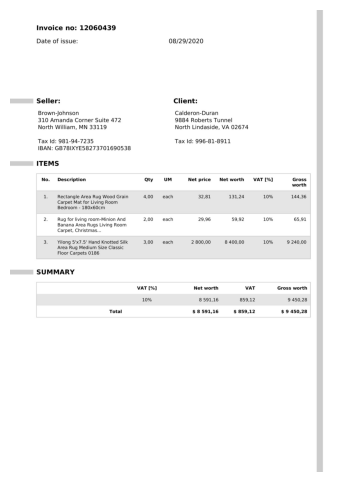

In [25]:
from PIL import Image
import matplotlib.pyplot as plt

# Ruta de la imagen de la factura
invoice_image_path = 'data/invoice_0_charspace_1.jpg'

# Cargar la imagen
image = Image.open(invoice_image_path).convert("RGB")

# Mostrar la imagen
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis('off')
plt.show()


In [62]:
from llama_index.multi_modal_llms.gemini import GeminiMultiModal
from llama_index.core.program import MultiModalLLMCompletionProgram
from llama_index.core.output_parsers import PydanticOutputParser
from llama_index.core.multi_modal_llms.generic_utils import load_image_urls
from llama_index.core import SimpleDirectoryReader

prompt_template_str = """\
    can you summarize what is in the image\
    and return the answer with json format \
"""

# Utilizar SimpleDirectoryReader para cargar las imágenes
def load_images_from_directory(directory_path):
    """Carga imágenes desde un directorio especificado."""
    reader = SimpleDirectoryReader(directory_path)
    image_documents = reader.load_data()
    return image_documents

# Asegúrate de que el directorio es correcto
directory_path = "data/"  # Asegúrate de que esta ruta es correcta para tu entorno
image_documents = load_images_from_directory(directory_path)

# Initialize the Gemini model
try:
    gemini_pro = GeminiMultiModal(model_name="models/gemini-1.5-flash")
except Exception as e:
    print(f"Error initializing Gemini model: {e}")
    raise

# Define the function for data extraction using Pydantic and Gemini
def pydantic_gemini(model_name, output_class, image_documents, prompt_template_str):
    gemini_llm = GeminiMultiModal(api_key=GOOGLE_API_KEY, model_name=model_name)

    llm_program = MultiModalLLMCompletionProgram.from_defaults(
        output_parser=PydanticOutputParser(output_class),
        image_documents=image_documents,
        prompt_template_str=prompt_template_str,
        multi_modal_llm=gemini_llm,
        verbose=True,
    )

    response = llm_program()
    return response

In [63]:
# Execute data extraction
try:
    invoice_data_response = pydantic_gemini(
        "models/gemini-1.5-flash",
        InvoiceData,
        image_documents,
        prompt_template_str,
    )

    # Display the results
    for response in invoice_data_response:
        print(response)

except Exception as e:
    print(f"An error occurred: {e}")

An error occurred: '\n  "invoice_number"'


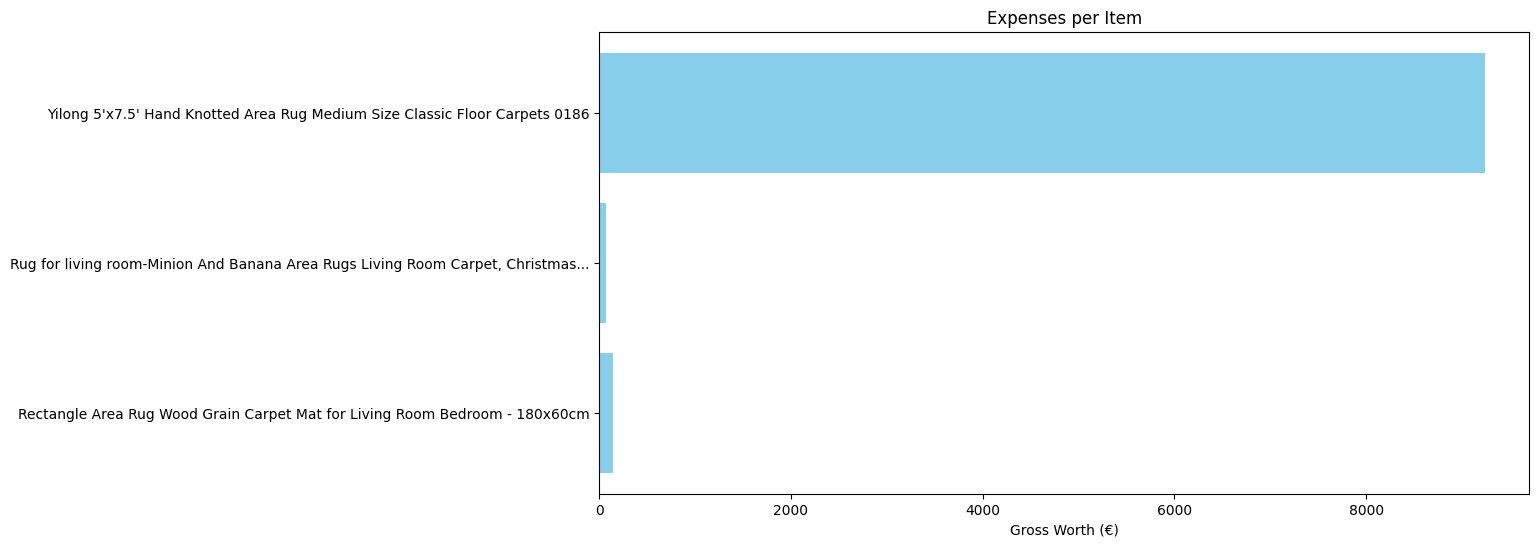

In [53]:
import matplotlib.pyplot as plt

# Extraer los datos de los artículos de la factura
items = [
    InvoiceItem(description='Rectangle Area Rug Wood Grain Carpet Mat for Living Room Bedroom - 180x60cm', quantity=4.0, unit_price=32.81, vat_percentage=10.0, gross_worth=144.36),
    InvoiceItem(description='Rug for living room-Minion And Banana Area Rugs Living Room Carpet, Christmas...', quantity=2.0, unit_price=29.96, vat_percentage=10.0, gross_worth=65.91),
    InvoiceItem(description="Yilong 5'x7.5' Hand Knotted Area Rug Medium Size Classic Floor Carpets 0186", quantity=3.0, unit_price=2800.0, vat_percentage=10.0, gross_worth=9240.0)
]

# Preparar datos para el gráfico
descriptions = [item.description for item in items]
gross_worths = [item.gross_worth for item in items]

# Crear gráfico de barras
plt.figure(figsize=(12, 6))
plt.barh(descriptions, gross_worths, color='skyblue')
plt.xlabel('Gross Worth (€)')
plt.title('Expenses per Item')
plt.show()


In [54]:
import numpy as np

# Simular datos históricos de ventas
historical_data = [150.0, 200.0, 250.0, 275.0, 300.0, 325.0, 350.0]

# Calcular el promedio y desviación estándar
mean_historical = np.mean(historical_data)
std_historical = np.std(historical_data)

# Comprobar si el total actual es una anomalía
current_total = 9450.28
if abs(current_total - mean_historical) > 2 * std_historical:
    print("Alerta: El total de la factura es un valor atípico.")
else:
    print("El total de la factura está dentro de los rangos normales.")


Alerta: El total de la factura es un valor atípico.


In [55]:
import pandas as pd

# Convertir los datos de los artículos a un DataFrame de Pandas
df_items = pd.DataFrame([item.dict() for item in items])

# Exportar a CSV
df_items.to_csv('invoice_items.csv', index=False)


In [61]:
# # %pip install statsmodels 

# from statsmodels.tsa.seasonal import seasonal_decompose

# # Supongamos que tienes una serie temporal de ventas mensuales
# sales_data = pd.Series([0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 620, 700, 750, 800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200],
#                        index=pd.date_range(start='2023-01-01', periods=12, freq='M'))

# # Descomposición estacional
# result = seasonal_decompose(sales_data, model='multiplicative')
# result.plot()
# plt.show()
